In [1]:
import numpy as np
import os
import pickle
import torch
from torch import nn
import torch.multiprocessing as mp
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

from rollout import Rollout
from controller import Controller

device = torch.device('cuda')
mp.set_start_method('spawn')

In /home/piyush/.conda/envs/kaggle/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/piyush/.conda/envs/kaggle/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/piyush/.conda/envs/kaggle/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/piyush/.conda/envs/kaggle/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/piyush/.conda/e

In [2]:
frames = np.load("data/frames.npy")
frames = frames.reshape(frames.shape[0], -1)
frames = frames / 255
frames = frames.astype(np.float64)
print(frames.shape)

(10000, 27648)


In [3]:
try:
    with open("models/vision.model", 'rb') as file:
        pca = pickle.load(file)
except FileNotFoundError:
    pca = PCA(n_components=288)
    pca.fit(frames)
    with open("models/vision.model", 'wb') as file:
        pickle.dump(pca, file)

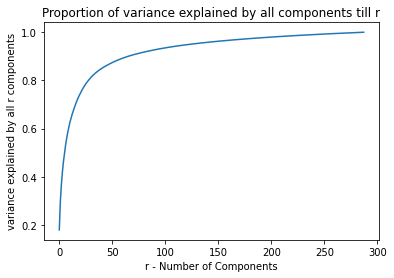

In [4]:
plt.plot(np.cumsum(pca.explained_variance_)/np.sum(pca.explained_variance_))
plt.title("Proportion of variance explained by all components till r")
plt.xlabel("r - Number of Components")
plt.ylabel("variance explained by all r components")
plt.show()

In [5]:
restore = True
if restore:
    cont = torch.load("models/controller-best-phase-1.pt")
else:
    nodes = 288
    cont = Controller(nodes)
cont.to(device)
cont.share_memory()
cont.eval()

cont.__name__ = 'global'

In [6]:
curr_best_score  = curr_mean_score = 0

In [7]:
from collections import OrderedDict 

NUM_GENERATION = 100
NUM_AVERAGE_REWARD_OVER = 4

def param2numpy(model):
    params = model.parameters()
    w = next(params) # shape 3x288
    b = next(params) # shape 3
    flat = torch.cat([w.flatten(), b], dim=-1)
    return flat.detach().cpu().numpy()

def load_param(model, params):
    w, b = params[:864], params[864:]
    w, b = [torch.tensor(i).cuda() for i in (w, b)]
    w = w.reshape(3, 288)
    updated_dict = OrderedDict({"fc.weight":w, "fc.bias":b})
    model.load_state_dict(updated_dict)

def get_reward_for_solution(soln):
    global cont
    global pca
    load_param(cont, soln)
    cont.double()
    
    pool = mp.Pool(processes=4)
    rewards = pool.starmap(Rollout, [[pca, cont, False] for i in range(4)])
    pool.close()

    return -np.mean(rewards).item()

In [8]:
import cma
es = cma.CMAEvolutionStrategy(param2numpy(cont), 0.1)

(12_w,24)-aCMA-ES (mu_w=7.0,w_1=24%) in dimension 867 (seed=308685, Tue Nov 24 16:56:06 2020)


In [ ]:
for generation in range(NUM_GENERATION):
    assert cont.__name__ == 'global'

    print("Generation:: {}..".format(generation + 1))
    solutions = es.ask(24)

    function_values = [get_reward_for_solution(s) for s in solutions]

    if -min(function_values) > curr_best_score:
        curr_best_score = -min(function_values)
        torch.save(cont, "models/controller-best-phase-2.pt")
        print("Best saved with reward {}".format(-min(function_values)))

    if generation%10==0:
        torch.save(cont, "models/controller-generation-{}-phase-2.pt".format(generation))
        print("Model saved as: models/controller-generation-{}-phase-2.pt".format(generation))

    es.tell(solutions, function_values)
    es.logger.add()
    es.disp()

torch.save(cont, "models/controller-generation-last")

Generation:: 1..
Best saved with reward 356.81451614513423
Model saved as: models/controller-generation-0-phase-2.pt
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     24 -3.568145161451342e+02 1.0e+00 9.91e-02  1e-01  1e-01 20:40.9
Generation:: 2..
    2     48 -3.393237632951692e+02 1.0e+00 9.83e-02  1e-01  1e-01 41:16.3
Generation:: 3..
    3     72 -3.106843643698775e+02 1.0e+00 9.76e-02  1e-01  1e-01 61:56.8
Generation:: 4..
Best saved with reward 408.85248898540806
    4     96 -4.088524889854081e+02 1.0e+00 9.68e-02  1e-01  1e-01 82:33.4
Generation:: 5..
    5    120 -3.931747219128434e+02 1.0e+00 9.62e-02  1e-01  1e-01 103:03.4
Generation:: 6..
Best saved with reward 415.5138948552819
    6    144 -4.155138948552819e+02 1.0e+00 9.55e-02  1e-01  1e-01 123:34.7
Generation:: 7..
Best saved with reward 463.88141432273494
    7    168 -4.638814143227349e+02 1.0e+00 9.49e-02  9e-02  9e-02 144:08.8
Generation:: 8..
    8    192 -4.481556667599655e+02 1.0